# PACKAGES

The following packages were needed to implement RTEA. The "PyGMO" package shown below as "pygmo" is a scientific library providing a large number of optimisation problems and algorithms. We used the package in order to use the following implementations:

- **fast_non_dominated_sorting:** An implementation of the fast non dominated sorting algorithm.
- **select_best_N_mo:** Sorts a population with respect to the following strict ordering:

          i)f1≺f2 if the non domination ranks are such that i1<i2.

          ii) In case i1=i2, then f1≺f2 if the crowding distances are such that  d1>d2.

For more information visit: https://esa.github.io/pagmo2/index.html

In [7]:
import pygmo as pg
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import random
import pandas as pd
import os
from sklearn import preprocessing
import itertools
import random

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression

from pySOT import *
from poap.controller import SerialController, ThreadController, BasicWorkerThread
from pySOT import check_opt_prob
from pygmo import hypervolume

import random
import sklearn.model_selection as xval
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as xval

# SIMULATION MODEL

In [8]:
#   ****************************************
#   ***   Code written by Jessica Wu     ***
#   ***        lw353@cornell.edu         ***
#   ****************************************

# Translated by Michael Luya from Matlab to Python on 3/4/2018.
# Updated by Aliya Jangabylova on 3/4/2018.

# Last updated 8/1/2012

# RETURNS: average total cost of production, transportation, outsourcing,
# and inventory holdings

import numpy as np
import randomstate as rnd
import random as rd

def SupplyChain(x, runlength = 2, seed = random.randint(1,10000)):
    
    x = np.reshape(x,(5,3))
# x is a 5x3 matrix, and it specifies the policy used to determine production
# runlength is the number of years to run the simulation
# seed is the index of the substreams to use (integer >= 1)
# other is not used

    if (np.sum(np.sum(k < 0 for k in x))>0 or (runlength <= 0) or
        (runlength != round(runlength)) or (seed <= 0) or (round(seed) != seed)):
        print('x should be >= 0, runlength should be positive integer, seed must be a positive integer\n')
        
    else:
        T = 52 # number of periods
        var = .3 # coeff of the variation of demand
        facilities = 3 # number of production plants
        salesRegions = 8
        products = 5 # number of products
        C = [.3, .5, .4, .2, .4] # production cost in dollars
        t = .02 # transportation cost 
        h = [.4, .3, .6, .2, .3] # inventory cost
        # e = [.8 .7 1.2 .9 1.1] # outsourcing cost
        e = [0.01, 0.01, 0.01, 0.01, 0.01] # outsourcing cost
        distance = np.array([[32, 21, 19, 31, 22, 35, 18, 33],
                            [25, 36, 30, 24, 16, 14, 31, 19],
                            [18, 12, 27, 11, 33, 28, 23, 22]]) # distance in miles from facility to sales region
        maximum = 70 # maximum order size
        minimum = 1 # minimum order size
        
    ## Generate data ##############################################################################################
    
    ExpectedStream = rnd.prng.mrg32k3a.RandomState(seed)
    DemandStream = ExpectedStream # MODIFIED JUAN
    
    U = np.round(ExpectedStream.normal(6,2,size = [5,8])); # mean demand from each region for each product
    U = U.astype(int)
    
    demands = np.zeros((products, salesRegions, T*runlength))
    
    for i in range(0,T*runlength): 
        
        demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))
        
        #The while loop runs until the accumulated demand is between minimun and maximun (JUAN)
        while np.sum(np.sum(k < minimum for k in demands[:,:,i])) or np.sum(np.sum(k > maximum for k in demands[:,:,i])):
            
            demands[:,:,i] = np.round(DemandStream.normal(U,np.sqrt(var)))

    ## Main Simulation ############################################################################################
    
    P = np.zeros((products,facilities, T*runlength)) # amount produced
    S = np.zeros((products,facilities, T*runlength)) # amount transported
    O = np.zeros((products,salesRegions, T*runlength)) # amount outsourced
    I = np.zeros((products,facilities, T*runlength+1)) # inventory levels
    serviceLevel = 0
    
    targetInventory = np.zeros((products, facilities))
  
    # COMPUTES THE INVENTORY IN EACH FACILITY TO SUPPLY THE THREE NEAREST SALES REGIONS.
    # IF X=1's the inventory is equal to the demand. COMMENT JUAN
    for i in range(0,facilities):       
        base = 0    
        for j in range(0,3):     
            low = 1000
            index = 0         
            for k in range(0,salesRegions): # finding the three closest sales regions           
                dki = distance[i,k] #COMPUTING DISTANCE BETWEEN FACILITIES AND SALES REGIONS. CHANGED BY JUAN
                if dki < low and dki >base:            
                    low = dki
                    index = k         
            base = low
            targetInventory[:,i] = targetInventory[:,i] + U[:,index] # targetInv at facility i and mean demand at sales region_index
            # total targetInventory from all facilities
#     print('Mean Demand')
#     print(U)
    
    targetInventory = np.multiply(targetInventory, x) #JBR
  
    for i in range(0,T*runlength):
#         print('Inventory lvl:' ,I[:,:,i])
#         print('Demand product x SalesRegion:' ,demands[:,:,i])
#         print('targetInventory: ',targetInventory)
#         print('Amount Produced(P) products x facilities: ',P[:,:,i])
#         print('Amount Transported(S) products x facilities: ',S[:,:,i])
#         print('Amount Outsourced(O) products x salesregions: ',O[:,:,i])
        if (I[:,:,i] < targetInventory).all(): #MODIFIED JUAN. Now produces everytime there's a shortage in any product on inventary
            P[:,:,i] = targetInventory - I[:,:,i] # producing to the target inventory level
            I[:,:,i] = I[:,:,i] + P[:,:,i]  # total amount of target inventory level

        #FINDING CLOSEST FACILITY. SAME STRUCTURE AS BEFORE.COMMENT BY JUAN. 
        for j in range(0,salesRegions):
            base = 0
            for m in range(0,3):   
                low = 1000
                index = 0
                for k in range(0,facilities): # find the closest facilities 
                    dkj = distance[k,j] # CHANGED BY JUAN
                    if dkj < low and dkj > base:  
                        low = dkj
                        index = k
                    
                for k in range(0,products): # facility fills the orders
                    
                    if demands[k,j,i] > I[k,index,i] and demands[k,j,i] > 0:
                        
                        demands[k,j,i] = demands[k,j,i] - I[k,index,i]  # total demand - inv.levels
                        S[k,index,i] = I[k,index,i]  # amount transported = inventory levels
                        I[k,index,i] = 0
                        I[k,index,i+1] = I[k,index,i] #MODIFIED JUAN
                        
                    elif demands[k,j,i] <= I[k,index,i] and demands[k,j,i] > 0:
                        
                        S[k,index,i] = demands[k,j,i] # transport all the demands
                        demands[k,j,i] = 0  # zero demands left
                        I[k,index,i] = I[k,index,i] - S[k,index,i]  # inv.level at facility..- amount transported
                        #if i < T*runlength-1:   # otherwise i+1 is bigger than the size T*runlength #MODIFIED JUAN
                        I[k,index,i+1] = I[k,index,i]
                                        
                    base = low # to find the next closest facility


            for k in range(0,products):
                
                if demands[k,j,i] > 0: # remaining order is filled by outsourcing
                    
                    O[k,j,i] = demands[k,j,i]
                    demands[k,j,i] = 0
                    serviceLevel += 1
                    
            

# Single objective 
    costs = np.sum(C*np.sum(np.sum(P,axis = 2),axis = 1)) + np.sum(t*np.sum(np.sum(S,axis = 2),axis = 1)) + np.sum(e*np.sum(np.sum(O,axis = 2),axis = 1))+ np.sum(h*np.sum(np.sum(I,axis = 2),axis = 1))
                
    
    ## End of Simulation; Generate results ######################################################################
    
    fn =  costs/runlength/np.sum(np.sum(np.sum(P,axis = 2),axis = 1)) # cost function
    fn2 = np.float((products*salesRegions*runlength*T - serviceLevel))/np.float(products*salesRegions*T*runlength) #customer service level

    return [fn, -fn2]

# ALGORITHM SETTING AND SOLUTION

class **RTEA_SURR** is the optimisation algorithm used for Supply Chain. This recives just the initial population size,evaluations to the supply chain code and the parameter k as input.

In [9]:
class RTEA_SURR:

    def evolve(self, pop, evaluations=4000, k_iterations=1):
        # If the population is empty (i.e. no individuals) nothing happens
        g = evaluations    #number of evaluations made
        pop_size = pop     #Initial population size
        p_cross = 0.95     # Probability to a apply crossover to a generated individual 
        lb = 0.6           #Lower Bound of each element of the input variable
        ub = 1.1           #Upper Bound of each element of the input variable
        cont_dim = 15      #Dimension of the input variable. This will be resized inside Supply Chain code as a 5x3 matrix   
        search_proportion = 0.95   #Percentage of iterations that pass before turning off main part of the algorithm and just apply the Rolling Tide loop (SEE JUST --SECOND BIG LOOP--)
        t=pop              #Counts the number of evaluations made in the supply chain code.
 
        #%%%%%%%%%%%%%%%%%% Just applicable for stats shown in the report for hypervolume computation
        rf = True
        HyperC_list = []
        ref_point = [ 1.0 , -0.1] # reference point set for hypervolume computation.
        #%%%%%%%%%%%%%%%%%%%
        
        INDV_F ={}        #Dictionary with a numerical tag for each individual and all the Objective function values obtained from re-evaluation.
        POPU_X = {}      #Dictionary with a numerical tag for each individual and the associated decision variable.
        POPU_F = {}      #Dictionary with a numerical tag for each individual and the associated ESTIMATION of Objective function. For each individual, this is the mean of INDV_F
        samples_A = {}   #Number of re-evaluations for each non-dominated individual.
        samples_pop = {} #Number of re-evaluations for all individuals. Dominated and non-dominated.

        #INITIALIZING RANDOM POPULATION
        
        for j in range(pop_size):
            POPU_X[j] = [random.uniform(lb,ub) for i in range(cont_dim)]
            POPU_F[j] = list(SupplyChain(list(POPU_X[j]),2,random.randint(1,1000)))
            INDV_F[j] = [POPU_F[j]]
        
        #LEGEND 
        
        #A:Decision variable "x" of Non-Dominated individuals
        #F: Value of Decision variable "SupplyChain(x)" of non-Dominated individuals.
        #X: Decision variable "x" of Dominated individuals.
        #Y:Value of Decision variable "SupplyChain(x)" of Dominated individuals.

        A,F,X,Y = get_A_F(POPU_X,POPU_F) #Get non-dominated individuals decision vectors and value from initial population 

        for i in A.keys():  #This loops set the counter to 1 for each individual
            samples_A[i] = 1
            samples_pop[i] = 1      
        M = len(POPU_X)-1 #M is just an auxiliary variable inside the code
        
        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #RF_best gets the best parameters for random forest from the initial random popuplation.
        rfr = RF_best(A.values()+X.values(), F.values()+Y.values())
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        

        #LVL1. Checks if the condition if the 4000 iterations passed in order to stop the optimisation algorithm.
        while t<=g:
            #print(t,' evaluations made in Supply Chain code')   #Sanity check

            
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%Trains random forest for each iteration of the algorithm
            #inputs are the decision values of the non-dominated and dominated set and their values.
            rfr.fit(A.values()+X.values(), F.values()+Y.values())
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            #This part only calculates the Hypervolume computation for each iteration. In case where this is not necessary, it can be set as comment.
            F1 = []
            F2 = []
            
            Obj_val = F.values()
            
            F1 = [ Obj_val[j][0] for j in range(len(Obj_val))]
            F2 = [ Obj_val[j][1] for j in range(len(Obj_val))]
            
            F_HV = [[ F1[i],F2[i]] for i in range(len(F1))]            
            hv = hypervolume(F_HV)

            HVval = hv.compute(ref_point)
            HyperC_list.append(HVval)
            #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
            #FIRST LOOP
            #The main objective of this loop is generate new individuals using a simple crossover and mutation.
            #After the new individual is created the sets A,F and X,Y are updated.
            if t< search_proportion*g: #In the case of 4000 total evaluations, the algorithm will spend 3800 evaluations creating new individuals
                
                aux_F = F.values()  #Auxiliary list F
                aux_A = A.values()  #Auxiliary list A
                
                #SELECTION OF PARENTS 
                if len(aux_F) > 1:
                    u_i,v_i = pg.select_best_N_mo(aux_F,2) #USE CROWDING DISTANCE along with ranking to select best two individuals.
                    u , v = aux_A[u_i],aux_A[v_i]
                else:
                    u , v = A.values()[0],A.values()[0]                  
        
                #CROSSOVER. HERE GENERATES CHILDS SEQUENTIALLY UNTIL ONE IS ACCEPTED IN THE NON-DOMINATED FRONT
                #range(15) is a cap to the maximum number of generations. in case the cap is surpassed, the last
                #child generate will enter inside the (X,Y) set.
                
                for S_I in range(15):
                    if random.uniform(0,1) < p_cross:
                        father, mother = u,v
                        index1 = random.randint(1, len(father) - 2)
                        index2 = random.randint(1, len(father) - 2)
                        if (index1 > index2):
                              index1, index2 = index2, index1
                        child = father[:index1] + mother[index1:index2] + father[index2:]
                        x = child
                    else:
                        x = u

                    #MUTATION, mutates the offspring
                    index = random.randint(0, len(x) - 1)
                    vary = random.uniform(lb, ub)
                    mutated = list(x)
                    mutated[index] = vary
                   
                    
                    #Estimate the child with surrogates
                    predict = rfr.predict([mutated]) 
                    pareto_front = pg.fast_non_dominated_sorting([list(flatten(predict))]+F.values())[0][0]

                    if (0 in pareto_front): # the generated child belongs to the A set
                        M+=1
                        POPU_X[M] = mutated
                        POPU_F[M] = list(SupplyChain(mutated,2,random.randint(1,1000)))
                        INDV_F[M] = []
                        INDV_F[M].append(POPU_F[M])
                        break
                    if S_I == 14: #the cap was surpassed.
                        M+=1
                        POPU_X[M] = mutated
                        POPU_F[M] = list(SupplyChain(mutated,2,random.randint(1,1000)))
                        INDV_F[M] = []
                        INDV_F[M].append(POPU_F[M])

                #UPDATES A,F, X, Y, samples_A, samples_pop with new individual       
                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
                t+=1       
                     
            samples_A,samples_pop = update_A(samples_pop,A)
            
            #SECOND LOOP. Re-evaluation or Rolling Tide part of the algorithm.
            #if k_iterations is set to 1, the algorithm will re-evaluate just once for each iteration.
            for k in range(k_iterations):
                
                #print(t,' evaluations made in Supply Chain code')   #Sanity check
                #finding element of A with smallest sample size
                x_pp = min(samples_A, key=samples_A.get)

                #evaluation of function
                DX = A[x_pp]
                y_pp = list(SupplyChain(list(DX),2,random.randint(1,1000)))
                
                #updating mean est(F)
                samples_A[x_pp] +=1
                samples_pop[x_pp] +=1
                INDV_F[x_pp].append(y_pp)               
                F0 = np.mean(np.matrix(INDV_F[x_pp])[:,0])
                F1 = np.mean(np.matrix(INDV_F[x_pp])[:,1])
                F_est = [F0,F1]
                POPU_F[x_pp] = F_est

                #+1 to the budget
                t+=1

                A,F,X,Y = get_A_F(POPU_X,POPU_F)
                samples_A,samples_pop = update_A(samples_pop,A)
                
        print('FINISHED.')
        return A,F,t,INDV_F,samples_A,HyperC_list,ref_point

## Auxiliary Functions

In [10]:
#get_A_F updates the sets A, F, X, Y 
def get_A_F(pop_X,pop_F):
    
    index_pareto_front = pg.fast_non_dominated_sorting(pop_F.values())[0][0]

    X = {}
    Y = {}
    A = {}
    F = {}
   
    #ELEMENTS PARETO FRONT
    for i in list(index_pareto_front):
        A[int(i)] = pop_X[int(i)]
        F[int(i)] = pop_F[int(i)]
    
    #ELEMENTS NON PARETO FRONT
    a = np.array([])
    for i in list(pg.fast_non_dominated_sorting(pop_F.values())[0][1:-1]):
        
        a = np.concatenate((a,i))
#         print("a length:", len(a))
    for i in list(a):
        X[int(i)] = pop_X[int(i)]
#         print("X:", X)
        Y[int(i)] = pop_F[int(i)]

    return A,F,X,Y

#update_A updates the samples_A and samples_pop 
def update_A(sample_pop,A_new):

    list_dif = A_new.keys()
    S = {}
    for i in list_dif:
        if i in sample_pop:
            S[i] = sample_pop[i]
        else:
            S[i] = 1
            sample_pop[i] = 1
    return S,sample_pop 

#calculate the best parameters given an input.
def RF_best(X, y):

    rfr = RandomForestRegressor()
    gs = GridSearchCV(rfr, param_grid = {'max_depth': [5, 7, 12, 15, 16, 20, 30],
                                    'n_estimators': [30, 50, 70, 100]},
                                      cv=5)

    X_train, X_test, y_train, y_test = xval.train_test_split(X, y, test_size=0.10)
    gs.fit(X_train, y_train)

    rfr_upd = gs.best_estimator_
    print(rfr_upd)
    
    return rfr_upd


def flatten(iterables):

    for i in itertools.chain(iterables):
        if hasattr(i, '__iter__'):
            for j in flatten(i): yield j
        else:
            yield i

# APLICATION OF THE ALGORITHM

In [11]:
#INPUT
#evl is the number of evaluations in the supply chain code
#pop_size is the initial random population size
#k is the number of re-evaluations for each iteration of the algorithm

#OUTPUT
#A: decision vector for non-dominated individuals.
#F: estimated value of the decision vector for non-dominated individuals.
#t number of evaluations made inside the algorithm
#samples_A: number of evaluations for each instance.
#INDV_F: value of each evaluation made for each instance.
#HV_curve: hypervolume metric taken inside the algorithm.
#ref_point: reference point taken for the hypervolume metric

evl =4000
pop_size =40
k=1
alg = RTEA_SURR()
A,F,t,IND,samples_A,HyperC_list,ref_point  = alg.evolve(pop_size,evaluations=evl,k_iterations=k)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
FINISHED.


# OUTPUT EXPLAMPLE EXPLANATION

In [12]:
#EXAMPLE TO UNDERSTAND OUTPUT.
#Let's choose first individual of A set.
print('tag of the first individual inside the A set')
print(A.keys()[0])
print('')
print('15 dimensional decision variable for that individual')
print(A[A.keys()[0]])
print('')
print('How many evaluations were taken for that individual (samples_A)')
print(samples_A[A.keys()[0]])
print('')
print('Estimated value of the decision variable (F)')
print(F[A.keys()[0]])

tag of the first individual inside the A set
1668

15 dimensional decision variable for that individual
[1.0604974838387995, 0.9028788386118607, 0.7631980105300478, 0.9148366505754666, 1.0094137087728505, 0.9898051506926621, 1.057278813421924, 0.7571788613242674, 0.7501594692423946, 0.8918794723904047, 0.9679536868469829, 0.7558739072685419, 0.8418811152545572, 0.9988510513451274, 0.942226608312552]

How many evaluations were taken for that individual (samples_A)
17

Estimated value of the decision variable (F)
[0.1868271612727996, -0.9463800904977377]


# OUTPUT PLOT

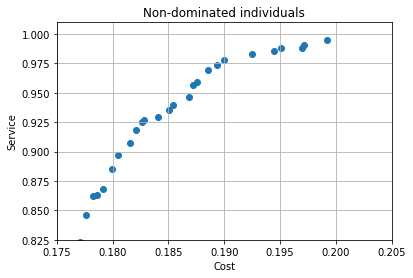

In [13]:
#RESULTING non-dominated front PLOT from 1 realization of the algorithm
#In order to compare the data with ESTECO's benchmark multiply by -1 the second objective function.

plt.scatter(np.array(np.matrix(F.values())[:,0]),-np.array(np.matrix(F.values())[:,1]))
plt.title('Non-dominated individuals')
plt.ylim((0.825,1.01))
plt.xlim((0.175,0.205))
plt.xlabel('Cost')
plt.ylabel('Service')
plt.grid()
plt.show()